# Comparison of data collected from scan vs focal sampling by species

Download ` scanvsfocal`  files used in this analysis from [kabr-methodology collection](https://huggingface.co/datasets/imageomics/kabr-methodology/tree/main/scanvsfocal) in Hugging Face.

In [13]:
"""
Script to generate a confusion matrix between field and drone focal sampling.
"""

import argparse
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import behavior
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Regex patterns (case-insensitive) → canonical label
CATEGORY_PATTERNS = {
    r"(vigilant|stand|head\s*up|alert\s*vigilance|vigilance|scanning)":            "Head Up",
    r"(fight|chase)":                                           "Out of Sight",
    r"(out\s*of\s*sight|out\s*of\s*focus|"
    r"out\s*of\s*frame|occluded|no\s*data)":                    "Out of Sight",
    r"(trot|trotting)":                                           "Trot",
    r"(run|running)":                                            "Run",
    r"(walk|walking)":                                          "Walk",
    r"sniff":                                                    "Graze",
    r"graze":                                                    "Graze",
    r"browse|browsing":                                          "Browse",
    r"auto[-\s]*groom":                                         "Auto-Groom",
}

def clean_categories(name: str) -> str:
    """
    Standardise free-text behaviour labels:
        * remove 'ing' variants (e.g. Running → Run)
        * merge Trot & Run
        * map all occlusion / missing-data phrases to 'Out of Sight'
    """
    text = name.lower()
    for pattern, canon in CATEGORY_PATTERNS.items():
        if re.search(pattern, text):
            return canon
    # If nothing matched, title-case the original so it fits the style
    return name.title()


def main():
    ground_truth_files = [
        "../data/plain/Scan-group_1.csv",
        "../data/plain/Scan-group_2.csv",
        "../data/grevys/Scan grevys group 1 morning 01_11.csv",
        "../data/grevys/Scan grevys group 2_a 01_11.csv",
        "../data/grevys/Scan grevys group 2_b 01_11.csv",
        "../data/grevys/Scan grevys group 2_c 01_11.csv",
        "../data/giraffe/Scan_giraffe_group_1.csv",
        # "../data/giraffe/focal1-female.csv",
        # "../data/giraffe/focal1-male.csv",
    ]
    cmp_files = [
        "../data/plain/Focal-group_1.csv",
        "../data/plain/Focal-group_2.csv",
        "../data/grevys/Focal grevys group 1 morning 01_11.csv",
        "../data/grevys/Focal grevys group 2_a 01_11.csv",
        "../data/grevys/Focal grevys group 2_b 01_11.csv",
        "../data/grevys/Focal grevys group 2_c 01_11.csv",
        # "../data/giraffe/Scan_giraffe_group_1.csv",
        "../data/giraffe/focal1-female.csv",
        "../data/giraffe/focal1-male.csv",
    ]
   
    
    minutes = 10

    ground_truth_samples = []
    for file in ground_truth_files:
        ground_truth_samples.extend(behavior.Focal.from_scan_file(file, clean_categories))

    cmp_samples = []
    for file in cmp_files:
        cmp_samples.extend(behavior.Focal.from_scan_file(file, clean_categories))
        

    # Lookup from behavior to integer
    behavior_lookup = {}
    for sample in ground_truth_samples + cmp_samples:
        for b in sample.behaviors:
            if b not in behavior_lookup:
                behavior_lookup[b] = len(behavior_lookup)
    

    # Start the matrix
    matrix = np.zeros((len(behavior_lookup), len(behavior_lookup)))

    # Go through all pairs of samples
    for ground_truth_sample, cmp_sample in zip(tqdm(ground_truth_samples), cmp_samples):
        for action in ground_truth_sample.relative_slice(
            datetime.timedelta(), datetime.timedelta(minutes=minutes)
        ):
            cmp_actions = cmp_sample.relative_slice(
                action.relative_start, action.relative_stop
            )

            for cmp_action in cmp_actions:
                matrix[behavior_lookup[action.name]][
                    behavior_lookup[cmp_action.name]
                ] += cmp_action.duration.seconds

    # Normalize matrix
    delete_from_both = []
    for x, row in enumerate(matrix):
        if sum(row) > 0:
            matrix[x] = [y / sum(row) for y in row]

        if sum(matrix[x, :]) == 0 and sum(matrix[:, x]) == 0:
            delete_from_both.append(x)
    
    matrix = np.delete(matrix, tuple(delete_from_both), axis=0)
    matrix = np.delete(matrix, tuple(delete_from_both), axis=1)
    
    cleaned_behavior_lookup = {}
    for b, old_idx in sorted(behavior_lookup.items(), key=lambda pair: pair[1]):
        if old_idx in delete_from_both:
            continue

        cleaned_behavior_lookup[b] = len(cleaned_behavior_lookup)
    behavior_lookup = cleaned_behavior_lookup

    # # Plot the matrix
    # fig, ax = plt.subplots()
    # im = ax.imshow(matrix)
    
    print("Behaviors found:", list(behavior_lookup.keys()))
    print("Number of behaviors:", len(behavior_lookup))
    
    return behavior_lookup, matrix


if __name__ == "__main__":
    cm = main()



 94%|█████████▍| 16/17 [00:00<00:00, 10825.76it/s]

Behaviors found: ['Graze', 'Head Up', 'Walk', 'Browse', 'Urinate', 'Auto-Groom', 'Run', 'Trot']
Number of behaviors: 8


In [14]:
import numpy as np

# labels = [
#     "Graze", "Walk", "Head Up", "Trot/Run", "Browse", "Auto-Groom",
#      "Fight", "Out of Sight"
#     ]
labels = [
    "Graze", "Walk", "Head Up", "Run", 
    "Browse", "Trot", "Auto-Groom", "Out of Sight"]

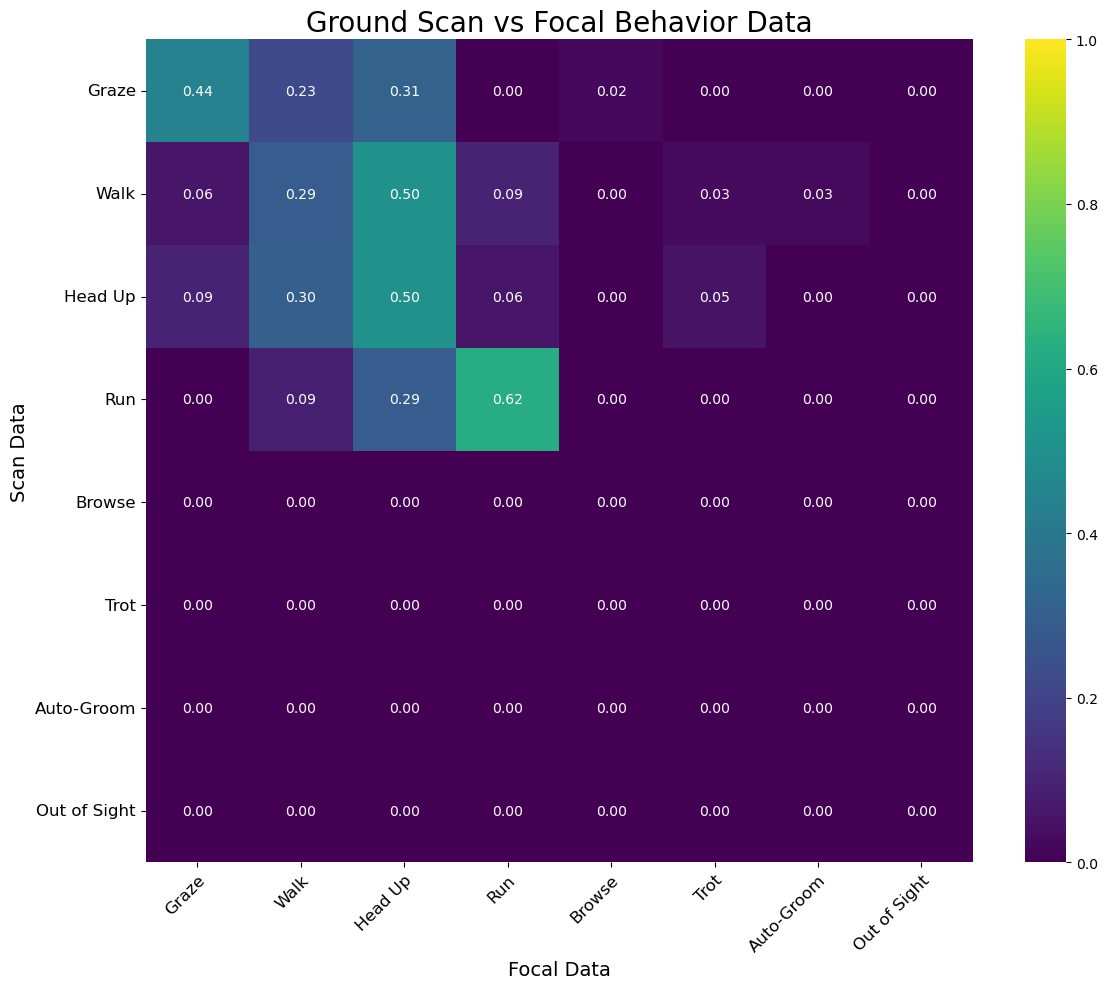

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm[1],
            annot=True, fmt=".2f",
            xticklabels=labels,
            yticklabels=labels,
            cmap='viridis', vmin=0, vmax=1)
ax.set_xlabel("Focal Data", fontsize=14)
ax.set_ylabel("Scan Data", fontsize=14)
ax.set_title("Ground Scan vs Focal Behavior Data", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

fig.savefig("../field_scan_vs_focal_sampling.pdf", dpi=300)

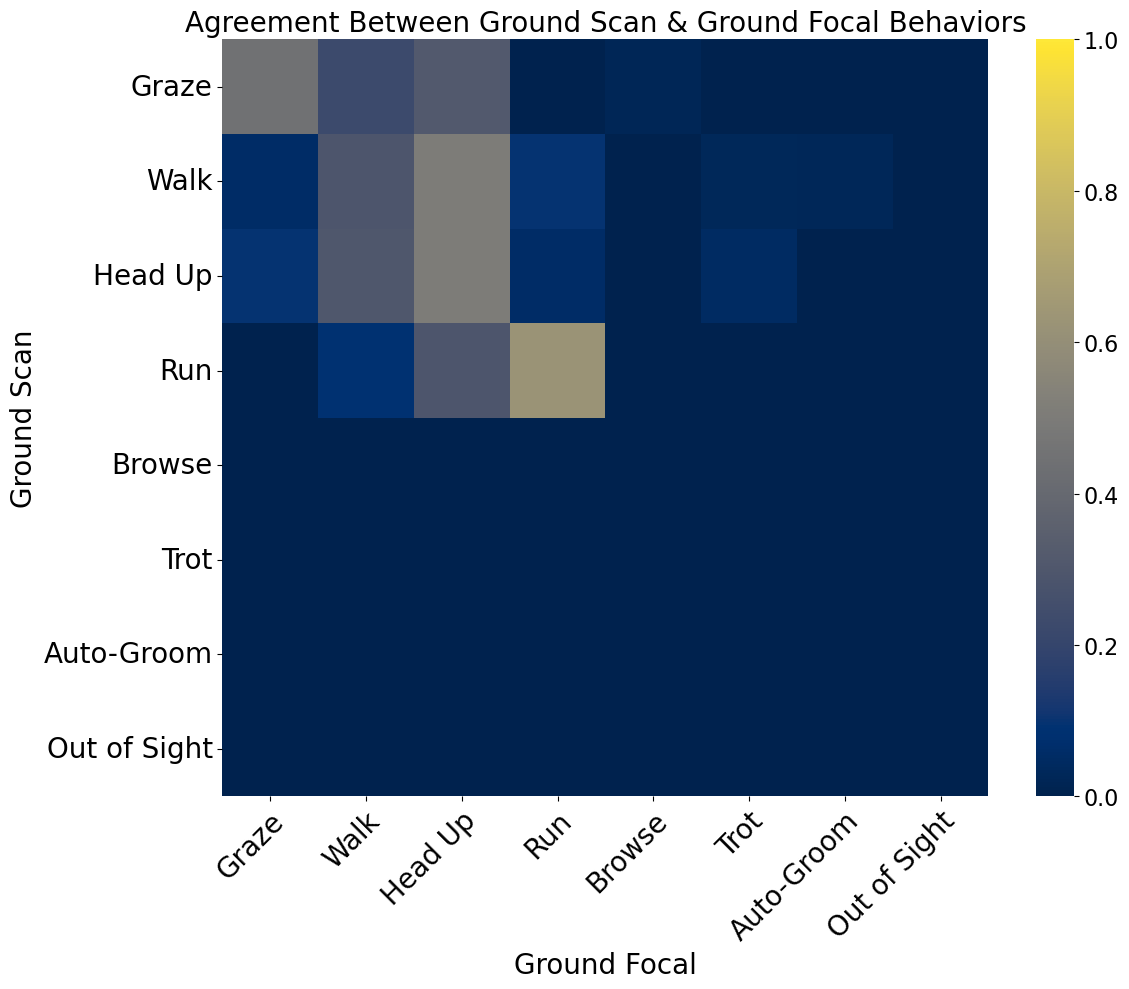

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(cm[1],
            annot=False, fmt=".2f",
            xticklabels=labels,
            yticklabels=labels,
            cmap='cividis', vmin=0, vmax=1)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel("Ground Focal", fontsize=20)
ax.set_ylabel("Ground Scan", fontsize=20)
ax.set_title("Agreement Between Ground Scan & Ground Focal Behaviors", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=20)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig("../field_scan_vs_focal_sampling.pdf", dpi=300)